In [61]:
import sys
sys.path.append("../src")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from src.matrix_factorization import MatrixFactorization

In [60]:
# データの読み込み
with open("../input/yahoo_r3/ydata-ymusic-rating-study-v1_0-train.txt", "r") as f_train:
    train = pd.read_csv(f_train, delimiter="\t", header=None).values
    train[:,0:2] -= 1

with open("../input/yahoo_r3/ydata-ymusic-rating-study-v1_0-test.txt", "r") as f_train:
    test = pd.read_csv(f_train, delimiter="\t", header=None).values
    test[:,0:2] -= 1

# データの分割
train, val = train_test_split(train, test_size=0.30, random_state=42)
random, test = train_test_split(test, test_size=0.99, random_state=42)

# 少量の完全ランダムな嗜好度合いデータを用いて傾向スコアを推定する
# https://arxiv.org/abs/1602.05352
numerator = np.unique(train[:, 2], return_counts=True)[1]
numerator = numerator / numerator.sum()
denominator = np.unique(random[:, 2], return_counts=True)[1]
denominator = denominator / denominator.sum()
pscore = numerator / denominator


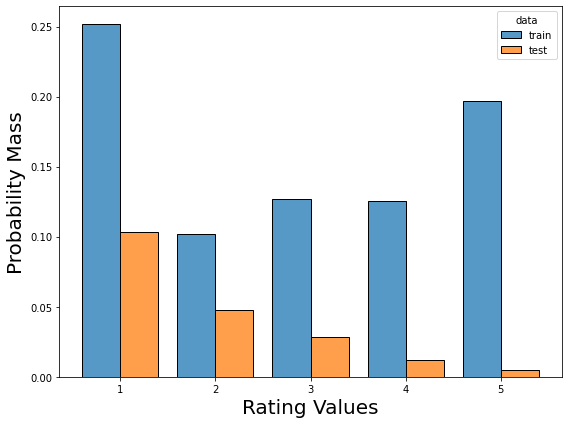

In [74]:
# trainとtestのレーティング分布の乖離の確認
train_df = pd.DataFrame(train).assign(data = "train")
test_df = pd.DataFrame(test).assign(data = "test")
data_df = pd.concat([train_df, test_df]).rename(columns={0: "user_id", 1: "item_id", 2: "rating"}).reset_index(drop=True)

plt.subplots(1, figsize=(8,6))
sns.histplot(data_df, x="rating", hue="data", stat="probability", discrete=True, multiple="dodge", shrink=0.8)
plt.xlabel("Rating Values", fontdict={"size": 20})
plt.ylabel("Probability Mass", fontdict={"size": 20})
plt.tight_layout()
plt.show()

In [75]:
# ナイーブ推定量に基づく学習
mf_naive = MatrixFactorization(
    k=10,
    learning_rate=1e-4,
    reg_param=1e-4,
    random_state=42
)
val_loss_naive, test_loss_naive = mf_naive.fit(
    train=train, val=val, test=test, n_epochs=100
)

100%|██████████| 100/100 [39:14<00:00, 23.55s/it]


In [77]:
# IPS推定量に基づく学習
mf_ips = MatrixFactorization(
    k=10,
    learning_rate=1e-4,
    reg_param=1e-4,
    random_state=42,
)
val_loss_ips, test_loss_ips = mf_ips.fit(
    train=train, val=val, test=test, pscore=pscore, n_epochs=100
)

100%|██████████| 100/100 [27:34<00:00, 16.55s/it]


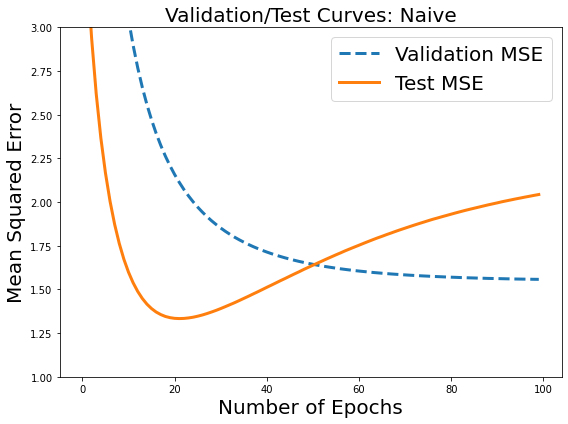

In [80]:
# ナイーブ推定量の学習曲線
plt.subplots(1, figsize=(8,6))
plt.plot(np.arange(len(val_loss_naive)), val_loss_naive, label="Validation MSE", linewidth=3, linestyle="dashed")
plt.plot(np.arange(len(test_loss_naive)), test_loss_naive, label="Test MSE", linewidth=3)
   
plt.title("Validation/Test Curves: Naive", fontdict=dict(size=20))
plt.xlabel("Number of Epochs", fontdict=dict(size=20))
plt.ylabel("Mean Squared Error", fontdict=dict(size=20))
plt.ylim([1.0, 3.0])
plt.tight_layout()
plt.legend(loc="best", fontsize=20)
plt.show()

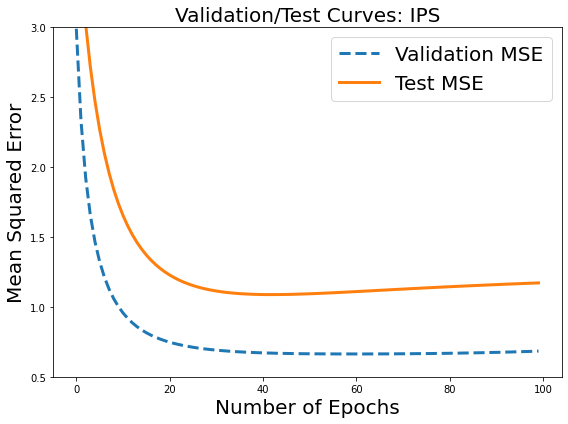

In [81]:
# IPS推定量の学習曲線
plt.subplots(1, figsize=(8,6))
plt.plot(np.arange(len(val_loss_ips)), val_loss_ips, label="Validation MSE", linewidth=3, linestyle="dashed")
plt.plot(np.arange(len(test_loss_ips)), test_loss_ips, label="Test MSE", linewidth=3)
 
plt.title("Validation/Test Curves: IPS", fontdict=dict(size=20))
plt.xlabel("Number of Epochs", fontdict=dict(size=20))
plt.ylabel("Mean Squared Error", fontdict=dict(size=20))
plt.ylim([0.5, 3.0])
plt.tight_layout()
plt.legend(loc="best", fontsize=20)
plt.show()

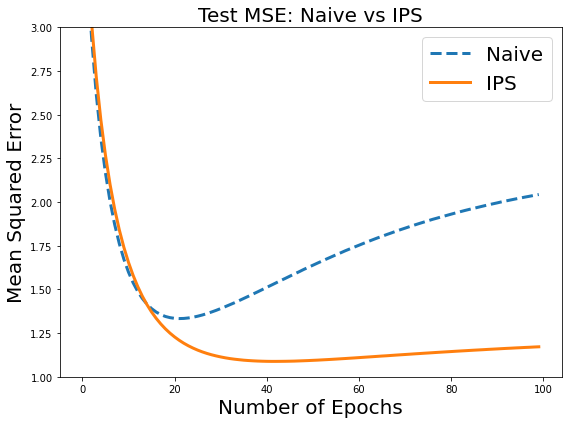

In [82]:
# ナイーブ推定量・IPS推定量のテストデータに対する茣蓙
plt.subplots(1, figsize=(8,6))
plt.plot(np.arange(len(test_loss_naive)), test_loss_naive, label="Naive", linewidth=3, linestyle="dashed")
plt.plot(np.arange(len(test_loss_ips)), test_loss_ips, label="IPS", linewidth=3)
   
plt.title("Test MSE: Naive vs IPS", fontdict=dict(size=20))
plt.xlabel("Number of Epochs", fontdict=dict(size=20))
plt.ylabel("Mean Squared Error", fontdict=dict(size=20))
plt.ylim([1.0, 3.0])
plt.tight_layout()
plt.legend(loc="best", fontsize=20)
plt.show()